In [1]:
# 01/01/2022 Luís
# In this notebook, we use the Machine Learning model which has been already developed
# to try and predict the parameters c10 and c01 of the Mooney Rivilin model from the
# respective stress-strain curves

# The number of increments for each curve has been greatly reduced.
# The number of combinations of c10 and c01 has been increased.

# Should have added some noise to the stress data. Will later update the notebook.

# 02/01/2022 Luís
# I've tried to add some noise, but the model fails to perform.
# The most probable 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import ast
import seaborn as sns
from sklearn.model_selection import train_test_split

import pandas as pd
import random
import sympy as sym
import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

In [3]:
def mooney_rivlin_equibiaxial(params, stretch):
    #returns cauchy stress at xx direction (stressxx == stressyy)
    
    # Right Cauchy-Green Deformation Tensor 'C'
    C11 = sym.Symbol('C11')
    C22 = sym.Symbol('C22')
    C33 = sym.Symbol('C33')
    C = sym.Matrix([[C11,0,0], [0,C22,0], [0,0,C33]])  
    
    # Compute the invariants I1 and I2 of the tensor C
    i1=sym.trace(C)
    i2 = C11*C22 + C22*C33 + C33*C11
    
    #Generate SEF (Strain Energy Function)
    #symbolic C10 and C01
    c10s = sym.Symbol('c10s')
    c01s = sym.Symbol('c01s')
    sef=c10s*(i1-3) + c01s*(i2-3)
    #Second Piola Kirchoff Stresses
    S11=2*sym.diff(sef,C11)
    S22=2*sym.diff(sef,C22)
    S33=2*sym.diff(sef,C33)
    S = sym.Matrix([[S11,0,0], [0,S22,0], [0,0,S33]])
    
    # Deformation Gradient assuming incompressibility and a equibiaxial load
    F=sym.Matrix([[stretch,0,0], [0,stretch,0], [0,0,1/(stretch**2)]])
    Ft=sym.transpose(F)
    C=Ft*F

    C11v=C[0,0]
    C22v=C[1,1]
    C33v=C[2,2]
    
    cauchy=(F*S*Ft) # push-forward. cauchy stresses with no BCs
    stress=cauchy[0,0]-cauchy[2,2] # imposing of boundary conditions
    stress_abq=sym.Matrix([[stress,0,0], [0, stress,0], [0,0,0]]) # stress11 == stress22; stress33 == 0
    s11_val=stress_abq.subs([(C11, C11v), (C22, C22v), (C33, C33v), (c10s,params[0]), (c01s,params[1])])
    np.array(s11_val).astype(np.float64)
    
    return s11_val[0,0]

# The function now only returns s11_val[0,0]. This is because I
# will not include the values of stretch at this point in the Machine Learning model. 
# All stress vectors (y) are for the same stretch vectors (x), linearly spaced from st_min to st_max.

def get_curve(params,stretch_min,stretch_max,ninc):
    #stores Mooney-Rivlin equibiaxial runs between minimum and a maximum stretch
    lst=[mooney_rivlin_equibiaxial(params, stretch) for stretch in np.linspace(stretch_min,stretch_max,ninc)]
    return lst

In [4]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [5]:
#Initial data-----------------------------------------------------------------------------------------------------

C10min=0.1     #min C10 value
C10max=10.0    #max C10 value
C01min=0.1     #min C01 value
C01max=2.0     #max C01 value
decimals=2   #number of decimal cases of C10 and C01 variables

n_c10=20             #number of C10 variables
n_c01=20             #number of C01 variables
n = n_c10 * n_c01     #number of combinations
#
st_max=3.0             #applied stretch
st_min=1.0
ninc=100      #number of stretch increments
#------------------------------------------------------------------------------------------------------------------

In [6]:
# Generates random values for c10 and c01
c10_list = np.round(np.random.uniform(C10min, C10max, size=(n_c10, 1)), decimals)
c01_list = np.round(np.random.uniform(C01min, C01max, size=(n_c01, 1)), decimals)
params = np.array([])

# Computes the n combinations of c10 and c01 values
for i in c10_list:
    for j in c01_list:
        params = np.append(params, np.array([i,j]))
params = params.reshape(-1, 2)

np.random.shuffle(params)

In [7]:
# Append the combinations to a DataFrame

df = pd.DataFrame(params[:,0], columns = ['c10'])
df['c01'] = params[:,1]

# Later I will deal with duplicates

In [8]:
#generate (x,y) data for each unique c10 at the dataframe
df['data']=df.apply(lambda x : get_curve(x,st_min,st_max,ninc), axis=1)
df[0:10]

c10   c01                                               data
0  3.97  1.12  [0, 1.20892835161019, 2.37312992757219, 3.4998...
1  0.64  0.79  [0, 0.344206636883273, 0.684659364529703, 1.02...
2  5.97  1.34  [0, 1.73362225269418, 3.39803304978570, 5.0038...
3  6.56  1.46  [0, 1.90190665171901, 3.72769136513374, 5.4890...
4  5.97  1.32  [0, 1.72872218075042, 3.38811947653886, 4.9887...
5  6.56  1.74  [0, 1.97050765893161, 3.86648139058953, 5.6997...
6  2.16  1.12  [0, 0.782860587329290, 1.54428222364127, 2.288...
7  9.64  1.00  [0, 2.51422638595467, 4.91009405786368, 7.2038...
8  5.58  1.46  [0, 1.67121802796471, 3.27892299504959, 4.8331...
9  3.97  0.88  [0, 1.15012748828510, 2.25416704861008, 3.3191...

In [9]:
y = df.data[0]
x = np.linspace(st_min,st_max,ninc)

plt.plot(x,y)

In [10]:
# This step is necessary because the Keras model won't accept sympy.core.numbers.Float type values.

for i in range(df.shape[0]):
    for j in range(ninc):
        df.data[i][j] = float(df.data[i][j])
    
    # Add noise to the data
#    noise = 0.05
#    df.data[i] = df.data[i] + noise * (np.random.random(len(df.data[i])) - 0.5) * (np.max(df.data[i]) - np.min(df.data[i]))

# The model doesn't perform well with this level of noise (5%) probably because ninc (number of increments) is too low.
# It takes too much time to run higher ninc in my computer.

In [11]:
#y = df.data[0]
#x = np.linspace(st_min,st_max,ninc)

#plt.plot(x,y)

In [12]:
test_split = 0.1 #we will use 10% of the data for testing.
train_df, test_df = train_test_split(df, test_size = test_split)

#the training data will be spllited automatically by 80/20 during training using keras framework. 

In [13]:
# Let's check the array shapes: 
print('Training set: ',train_df.shape)
print('Test set: ',test_df.shape)

train_size = train_df.shape[0]
test_size = test_df.shape[0]

Training set:  (360, 3)
Test set:  (40, 3)


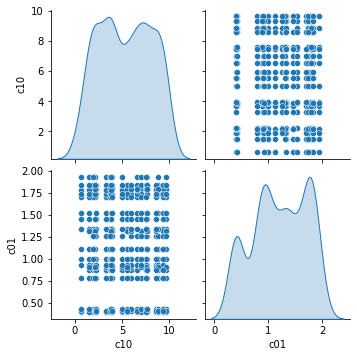

In [14]:
#inspect the training dataset
sns.pairplot(train_df[['c10','c01']], diag_kind='kde')

In [15]:
train_df.describe().transpose()

count      mean       std   min   25%   50%   75%   max
c10  360.0  5.328306  2.736443  0.64  3.30  5.58  7.63  9.64
c01  360.0  1.209500  0.491707  0.40  0.88  1.26  1.71  1.94

In [16]:
# Allocate the features and the labels in different DataFrames.

train_features = train_df.copy()
test_features = test_df.copy()

train_labels = pd.DataFrame([train_features.pop('c10'), train_features.pop('c01')])
train_labels = train_labels.T
test_labels = pd.DataFrame([test_features.pop('c10'), test_features.pop('c01')])
test_labels = test_labels.T

In [17]:
feature_columns = []

# Will not include the values of x (in this case stretch) at this point. 
# All stress vectors (y) are for the same stretch vectors (x), linearly spaced from st_min to st_max.

y_col = tf.feature_column.numeric_column("data")
feature_columns.append(y_col)

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [18]:
# Build the model and define its architecture.

In [19]:
inputs = keras.Input(shape=ninc)

dense = layers.Dense(512, activation="relu")
x = dense(inputs)

x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(2)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="model")

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 315,394
Trainable params: 315,394
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Set the hyperparameters

validation_split = 0.2
learning_rate = 0.0005
batch_size = 50
epochs = 20

In [22]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

In [23]:
# Convert the data arrays into tensors.

tf_train_features = tf.constant([train_features['data']], shape=(train_size,ninc))

tf_train_labels = tf.constant([np.array(train_labels)], shape=(train_size,2))

tf_test_features = tf.constant([np.array(test_features['data'])], shape=(test_size,ninc))

tf_test_labels = tf.constant([np.array(test_labels)], shape=(test_size,2))

In [24]:
history = model.fit(tf_train_features, tf_train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

test_scores = model.evaluate(tf_train_features, tf_train_labels, verbose=2)
print("Test loss:", test_scores)

Epoch 1/20
6/6 [==============================] - 1s 44ms/step - loss: 1433.5516 - val_loss: 848.5222
Epoch 2/20
6/6 [==============================] - 0s 12ms/step - loss: 478.2964 - val_loss: 150.5634
Epoch 3/20
6/6 [==============================] - 0s 14ms/step - loss: 182.7885 - val_loss: 11.8593
Epoch 4/20
6/6 [==============================] - 0s 14ms/step - loss: 95.6811 - val_loss: 11.3189
Epoch 5/20
6/6 [==============================] - 0s 14ms/step - loss: 51.2146 - val_loss: 32.8557
Epoch 6/20
6/6 [==============================] - 0s 14ms/step - loss: 29.9731 - val_loss: 31.2046
Epoch 7/20
6/6 [==============================] - 0s 14ms/step - loss: 17.8490 - val_loss: 17.8965
Epoch 8/20
6/6 [==============================] - 0s 14ms/step - loss: 9.4269 - val_loss: 2.8467
Epoch 9/20
6/6 [==============================] - 0s 14ms/step - loss: 3.6907 - val_loss: 0.6569
Epoch 10/20
6/6 [==============================] - 0s 14ms/step - loss: 2.1043 - val_loss: 2.6046
Epoch 11/

478.2913188827224


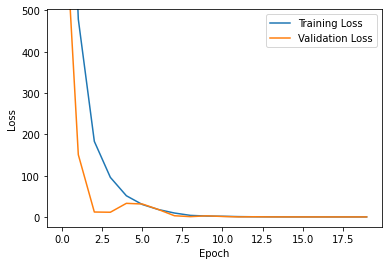

In [25]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [26]:
tf_test_labels

<tf.Tensor: shape=(40, 2), dtype=float64, numpy=
array([[6.56, 0.91],
       [5.97, 1.94],
       [6.99, 0.88],
       [1.51, 1.26],
       [5.03, 1.32],
       [8.58, 1.94],
       [2.16, 1.53],
       [9.64, 0.93],
       [3.86, 0.79],
       [3.68, 1.79],
       [3.97, 1.46],
       [5.58, 1.94],
       [0.64, 1.32],
       [0.64, 0.88],
       [5.97, 0.4 ],
       [5.97, 1.79],
       [3.3 , 0.43],
       [0.64, 1.8 ],
       [2.24, 1.32],
       [3.3 , 1.32],
       [6.99, 1.34],
       [2.24, 1.71],
       [2.24, 1.79],
       [3.97, 1.79],
       [8.85, 1.71],
       [8.85, 1.32],
       [1.89, 1.46],
       [0.64, 1.26],
       [6.56, 1.32],
       [2.24, 1.12],
       [2.16, 1.79],
       [7.63, 1.71],
       [2.24, 1.94],
       [3.68, 1.53],
       [5.58, 1.26],
       [7.5 , 1.74],
       [8.85, 1.46],
       [9.34, 1.94],
       [1.89, 1.53],
       [0.64, 0.91]])>

In [27]:
guesses = model.predict(tf_test_features)

guesses

array([[6.590846  , 0.96711266],
       [5.8481207 , 2.0235207 ],
       [6.9758806 , 0.9646293 ],
       [1.5134628 , 1.2740642 ],
       [4.969224  , 1.379943  ],
       [8.522283  , 2.0288537 ],
       [2.1348722 , 1.5541793 ],
       [9.492152  , 1.0256721 ],
       [3.84601   , 0.8273994 ],
       [3.572728  , 1.8404647 ],
       [3.8797138 , 1.515544  ],
       [5.459222  , 2.0178254 ],
       [0.7230633 , 1.3251392 ],
       [0.6738828 , 0.88841546],
       [5.8974695 , 0.4341747 ],
       [5.86514   , 1.8697807 ],
       [3.3016598 , 0.46770874],
       [0.7827042 , 1.7962371 ],
       [2.1853988 , 1.3490154 ],
       [3.219158  , 1.3661033 ],
       [6.9782057 , 1.4030296 ],
       [2.2276247 , 1.7329246 ],
       [2.2365034 , 1.8115684 ],
       [3.8618782 , 1.8446838 ],
       [8.833165  , 1.7900077 ],
       [8.889852  , 1.3868896 ],
       [1.8814323 , 1.4792548 ],
       [0.7156027 , 1.2662517 ],
       [6.539773  , 1.3817321 ],
       [2.172982  , 1.1511375 ],
       [2.

In [28]:
# relative error (%)

error_mat = (np.abs(tf_test_labels - model.predict(tf_test_features)) / tf_test_labels) * 100

error_mat

<tf.Tensor: shape=(40, 2), dtype=float64, numpy=
array([[ 0.47021436,  6.27611653],
       [ 2.04152949,  4.30519114],
       [ 0.20199395,  9.61696506],
       [ 0.22932331,  1.11620502],
       [ 1.20827085,  4.54113736],
       [ 0.67269697,  4.5800853 ],
       [ 1.16332416,  1.58034711],
       [ 1.53369073, 10.28732023],
       [ 0.36243602,  4.73409786],
       [ 2.91500221,  2.81925761],
       [ 2.27421225,  3.80438746],
       [ 2.16448316,  4.01161676],
       [12.97863908,  0.38933068],
       [ 5.29418476,  0.9563018 ],
       [ 1.2149159 ,  8.54367167],
       [ 1.75644956,  4.45702009],
       [ 0.05029765,  8.76947364],
       [22.29752727,  0.20904938],
       [ 2.43755281,  2.19813296],
       [ 2.44975957,  3.4926736 ],
       [ 0.16873132,  4.70369859],
       [ 0.55247077,  1.34061875],
       [ 0.15609988,  1.2049374 ],
       [ 2.72347212,  3.05495901],
       [ 0.19022408,  4.67881348],
       [ 0.45030023,  5.06739219],
       [ 0.45331773,  1.31882478],
      

In [29]:
error_avg = np.array([0.00,0.00])
error_avg[0] = np.average(error_mat[:,0])
error_avg[1] = np.average(error_mat[:,1])

In [30]:
error_avg # [avg error for c10, avg error for c01]

array([2.37990831, 3.67125668])

In [31]:
np.average(error_mat)

3.0255824954120616

In [32]:
np.std(error_mat)

3.52002008815835